In [16]:
import geopandas as gpd
import rasterio
from rasterize import rasterize_shapes_to_array
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import pandas as pd
from rasterio.crs import CRS

# Parameters

In [27]:
EVENT_NAME = 'brazzaville_flood_and_landslides_2024'

# Read Yaml

In [28]:
yaml_file = f'events/{EVENT_NAME}.yml' #'porto_algre.yml'

In [29]:
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'brazzaville_flood_and_landslides_2024',
 'bounds': [15.19418162, -4.31842285, 15.31481366, -4.13558505],
 'event_date': '2024-02-08',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [7, 109],
 'mgrs_tiles': ['33MWR'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange',
 'links': ['2024 and 2023 combined: https://data.humdata.org/dataset/water-and-landslide-mudflow-extents-in-brazzaville-department-republic-of-congo-as-of-8-fe',
  '2023: https://data.humdata.org/dataset/water-and-landslide-mudflow-extents-in-brazzaville-and-pool-departments-republic-of-congo-',
  '2024: https://global-flood.emergency.copernicus.eu/news/159-flooding-in-the-democratic-republic-of-the-congo-and-congo-brazzaville-january-2024']}

In [30]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [31]:
df_event.head()

,name,date,source_id,geometry
0,brazzaville_landslide_and_flood_2024,2024-02-08,UNOSAT via humanitarian data exchange,"MULTIPOLYGON (((15.20227 -4.24301, 15.20226 -4..."
1,brazzaville_landslide_and_flood_2024,2024-02-08,UNOSAT via humanitarian data exchange,"MULTIPOLYGON (((15.20338 -4.31840, 15.20329 -4..."


In [33]:
change_dir_hls = Path('out') / event_dict['event_name'] / 'change_map_dist_hls'
change_dir_hls.mkdir(exist_ok=True, parents=True)
change_map_tif = list(change_dir_hls.glob('*.tif'))[0]

with rasterio.open(change_map_tif) as ds:
    ref_profile = ds.profile
    ref_crs = ds.crs

In [22]:
df_event_utm = df_event.to_crs(ref_crs)

In [15]:
external_data_dir = Path(f'out/{event_dict["event_name"]}/validation_data')
external_data_dir.mkdir(exist_ok=True, parents=True)

X_val_rtc = rasterize_shapes_to_array(df_event_utm.geometry.tolist(), np.ones(df_event_utm.shape[0]), ref_profile, all_touched=True, dtype='uint8')

external_data_prof = ref_profile.copy()
external_data_prof['dtype'] = 'uint8'
external_data_prof['nodata'] = 255

event_name = event_dict['event_name']
source_id = event_dict.get('source_id', df_event_utm.source_id[0]) 
source_id = source_id.replace(' ', '_').lower()
source_id = source_id.replace('.', '_')
with rasterio.open(external_data_dir / f'{event_name}_{source_id}.tif', 'w', **external_data_prof) as ds:
    ds.write(X_val_rtc, 1)

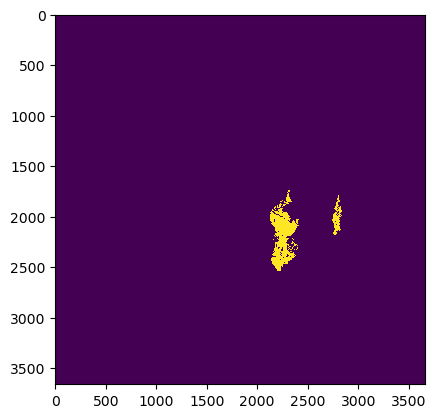

In [24]:
plt.imshow(X_val_rtc, interpolation='none')